# ==============================
# Comparação dos Algoritmos de Clustering
# ==============================
# Este notebook consolida os resultados obtidos pelos três algoritmos
# de clustering aplicados aos dados estelares e compara seus desempenhos
# utilizando o Silhouette Score.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

sns.set(style="whitegrid")

In [3]:
# ------------------------------
# Comparação dos Silhouette Scores
# ------------------------------

hier = pd.read_csv("../results/hierarchical_results.csv")
db   = pd.read_csv("../results/dbscan_results.csv")
gmm  = pd.read_csv("../results/gmm_results.csv")

results = pd.concat([hier, db, gmm], ignore_index=True)
display(results)

,Algoritmo,Silhouette Score,Número de Clusters
0,Agrupamento Hierárquico,0.781042,NaN
1,DBSCAN,0.582573,7.0
2,Gaussian Mixture Model (GMM),0.781042,NaN


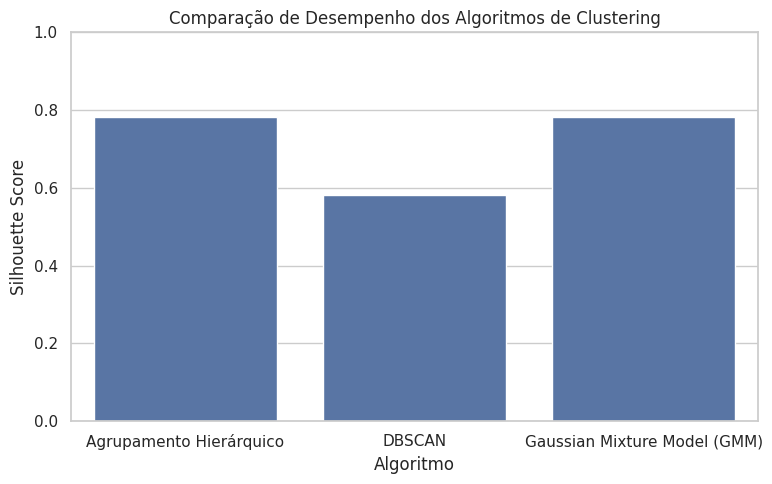

In [4]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=results,
    x="Algoritmo",
    y="Silhouette Score"
)

plt.title("Comparação de Desempenho dos Algoritmos de Clustering")
plt.xlabel("Algoritmo")
plt.ylabel("Silhouette Score")
plt.ylim(0, 1)
plt.tight_layout()

plt.savefig("model_performance_comparison.png", dpi=300)
plt.show()

In [5]:
# ------------------------------
# Carregar labels e classe espectral
# ------------------------------

labels_hier = pd.read_csv("../results/labels_hierarchical.csv", index_col=0)
labels_db   = pd.read_csv("../results/labels_dbscan.csv", index_col=0)
labels_gmm  = pd.read_csv("../results/labels_gmm.csv", index_col=0)

spectral_class = pd.read_csv("../results/spectral_class.csv", index_col=0)

In [6]:
# --------------------------------------------
# Cluster vs Classe Espectral - Hierárquico
# --------------------------------------------

# Padronizar nome da coluna
spectral_class = spectral_class.rename(
    columns={spectral_class.columns[0]: "Spectral_Class"}
)

comparison_hier = pd.concat(
    [labels_hier, spectral_class],
    axis=1
)

display(comparison_hier.head())

pd.crosstab(
    comparison_hier["cluster_hierarchical"],
    comparison_hier["Spectral_Class"]
)

,cluster_hierarchical,Spectral_Class
0,0,A
1,5,A
2,0,M
3,0,F
4,0,M


Spectral_Class,A,B,F,G,K,M
cluster_hierarchical,,,,,,
0,264,55,65,75,80,132
1,0,144,0,0,0,0
2,0,0,0,0,0,63
3,0,36,0,0,0,0
4,0,0,0,0,0,44
5,25,0,0,0,0,0
6,0,17,0,0,0,0


In [7]:
comparison_db = pd.concat(
    [labels_db, spectral_class],
    axis=1
)

pd.crosstab(
    comparison_db["cluster_dbscan"],
    comparison_db["Spectral_Class"]
)

Spectral_Class,A,B,F,G,K,M
cluster_dbscan,,,,,,
0,264,199,65,75,80,132
1,25,0,0,0,0,0
2,0,0,0,0,0,44
3,0,0,0,0,0,37
4,0,0,0,0,0,26
5,0,36,0,0,0,0
6,0,17,0,0,0,0


In [8]:
comparison_gmm = pd.concat(
    [labels_gmm, spectral_class],
    axis=1
)

pd.crosstab(
    comparison_gmm["cluster_gmm"],
    comparison_gmm["Spectral_Class"]
)

Spectral_Class,A,B,F,G,K,M
cluster_gmm,,,,,,
0,264,55,65,75,80,132
1,0,0,0,0,0,63
2,0,36,0,0,0,0
3,25,0,0,0,0,0
4,0,0,0,0,0,44
5,0,144,0,0,0,0
6,0,17,0,0,0,0


In [9]:
def evaluate_clustering(comparison_df, cluster_col, true_col="Spectral_Class"):
    # Mapear cluster → classe dominante
    cluster_to_class = (
        comparison_df
        .groupby(cluster_col)[true_col]
        .agg(lambda x: x.value_counts().idxmax())
    )

    # Predição "forçada" via cluster
    y_true = comparison_df[true_col]
    y_pred = comparison_df[cluster_col].map(cluster_to_class)

    # Relatório
    report = classification_report(
        y_true,
        y_pred,
        output_dict=True,
        zero_division=0
    )

    report_df = pd.DataFrame(report).T

    return report_df


In [10]:
metrics_hier = evaluate_clustering(
    comparison_hier,
    cluster_col="cluster_hierarchical"
)

metrics_hier["Algoritmo"] = "Hierarchical"

In [11]:
metrics_db = evaluate_clustering(
    comparison_db,
    cluster_col="cluster_dbscan"
)

metrics_db["Algoritmo"] = "DBSCAN"

In [12]:
metrics_gmm = evaluate_clustering(
    comparison_gmm,
    cluster_col="cluster_gmm"
)

metrics_gmm["Algoritmo"] = "GMM"

In [13]:
metrics_all = pd.concat(
    [metrics_hier, metrics_db, metrics_gmm]
)

summary_metrics = metrics_all.loc[
    ["weighted avg"]
][["precision", "recall", "f1-score", "Algoritmo"]]

display(summary_metrics)

,precision,recall,f1-score,Algoritmo
weighted avg,0.611001,0.593,0.538538,Hierarchical
weighted avg,0.590430,0.449,0.383357,DBSCAN
weighted avg,0.611001,0.593,0.538538,GMM
